# Examples of Pandas for Policy

We will pretty much _always_ need to import pandas and json, and run that magic line:

```
%matplotlib inline
```

## A Matrix of Disadvantage

Though there's a fair degree of mobility in high school, Chicago elementary schools are "fairly neighborhood-centered."  I want to visualize their environments, using data from the [Illinois Report Card](http://illinoisreportcard.com/District.aspx?source=SchoolsInDistrict&Districtid=15016299025), matched with the city's [crime data](https://data.cityofchicago.org/view/5cd6-ry5g), and census data.  As we might imagine, students who face one challenge often face many.  There is a 'matrix' of disadvantage: poor kids' parents tend to be less-educated; they attend less-performing schools and see more crime.

**THIS MEANS MERGING!!**

* The **school data** is extracted from multiple parts of the [Illinois Report Card](https://illinoisreportcard.com/).  You can see how this is done in `ex/school_scrape.py`.  We'll talk about scraping along with APIs, next week.
  * The data are in two parts: `data/chicago_schools.csv` contains the "PARCC Proficiency (%)" (the test result we'll use), and `data/school_address_geocoded.csv` contains the `CensusTract`.  You can **merge** them on the `ISBE_ID` (Illinois State Board of Education).  Make sure you have the census tract at each level, for your final merge.
  * We'll only want the K5 and K8 schools, so we'll have to do a **mask**.
* **Census** records of poverty and educational attainment for every census tract in Cook County are downloaded in `data/census.json`.
  * You can see the available variables [listed here](http://api.census.gov/data/2014/acs5/variables.html).  
  * Educational attainment (bachelor's): B16010_041E and B16010_001E (numerator and denominator)
  * Below the poverty line: B06012_002E and B06012_001E (numerator and denominator)
  * We'll see how to do this, next week.  For now, you can see the call, [here](https://api.census.gov/data/2014/acs5?for=tract:*&in=state:17+county:31&get=NAME,B16010_001E,B16010_041E,B06012_001E,B06012_002E).  (17 is Illinois and 31 is Cook County.)
* **Crime data** since 2001 comes from the [city's data portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), and did a spatial join (week 10) of their physical location to census tracts.  The crime counts per census tract are in `data/crime_tract_count.csv`.

### School Data

Start by importing the two school datasets and merging these.  Figure out which columns you really need in each, and drop schools with missing values.

First, the school report cards.  I will set the index to a specific column, using the `index_col` argument.  This will make our **join** easier, later.

We can also reduce the number of columns.

,Name,PARCC Proficiency (%),Grades
ISBE_ID,,,
150162990250848,AIR FORCE ACAD HIGH SCHOOL,9.4,9-12
150162990250849,ALCOTT HUMANITIES HIGH SCHOOL,14.3,9-12
150162990250001,AMUNDSEN HIGH SCHOOL,14.9,9-12
150162990250839,AUSTIN BUS & ENTREPRENEURSHIP HS,1.8,9-12
150162990250840,AUSTIN POLYTECHNICAL ACADEMY HS,3.4,9-12


We need to get rid of all of the blank entries.  We can do that with `dropna()` -- though this is not a perfect solution!!

Now let's import the geocoded schools.  There are a lot more columns than we need.  We can limit this using `usecols()`.

As above, we're setting `index_col = "ISBE_ID"`.  This means that joining the two datasets will be really easy!

We can also directly specify the `usecols` variable, to accomplish the same column reduction as above.  It takes as an argument, a list of the columns.  We just want ["ISBE_ID", "CensusTract"]

,CensusTract
ISBE_ID,
150162990250848,3406.00
150162990250849,514.00
150162990250001,404.02
150162990250839,2519.00
150162990250840,2519.00


Now put these together.  Since `df_sch_import` and `df_sch_geocode` share the index, we can use ... join or merge??

,Name,PARCC Proficiency (%),Grades,CensusTract
ISBE_ID,,,,
150162990250848,AIR FORCE ACAD HIGH SCHOOL,9.4,9-12,3406.00
150162990250849,ALCOTT HUMANITIES HIGH SCHOOL,14.3,9-12,514.00
150162990250001,AMUNDSEN HIGH SCHOOL,14.9,9-12,404.02
150162990250839,AUSTIN BUS & ENTREPRENEURSHIP HS,1.8,9-12,2519.00
150162990250840,AUSTIN POLYTECHNICAL ACADEMY HS,3.4,9-12,2519.00


I know that in a subsequent step, CensusTract will just be called `tract`, so I want to rename it, now:

,Name,PARCC Proficiency (%),Grades,tract
ISBE_ID,,,,
150162990250848,AIR FORCE ACAD HIGH SCHOOL,9.4,9-12,3406.00
150162990250849,ALCOTT HUMANITIES HIGH SCHOOL,14.3,9-12,514.00
150162990250001,AMUNDSEN HIGH SCHOOL,14.9,9-12,404.02
150162990250839,AUSTIN BUS & ENTREPRENEURSHIP HS,1.8,9-12,2519.00
150162990250840,AUSTIN POLYTECHNICAL ACADEMY HS,3.4,9-12,2519.00


For this work, let's just look at elementary schools.  Very approximately, these are schools that have kindergartners.  

In pandas, string functions on a column are accessible through `x.str.*`.

Create a mask on grades that selects elementary schools (`x.str.contains(...)`).

Finally, **aggregate** the average (`mean()`) PPARC rate, using a `groupby()` call.

(Should do school size weighted, but this is enough for now...)

,PARCC Proficiency (%)
tract,
101.00,12.7
102.01,13.8
106.00,20.4
107.02,27.3
202.00,40.5


### Crime Rates

Now import the crime counts, by census tract.  Again, we'll take the `tract` column as our index

### Census Data

We need to read in a json object from `data/census.json`.  What's the syntax?

Now we'll use the 2D list constructor with data as the main payload (all but the first element), and columns from the first element.

,NAME,B16010_001E,B06012_002E,B06012_001E,B16010_041E,state,county,tract
0,"Census Tract 101, Cook County, Illinois",2949,1212,4083,1138,17,031,010100
1,"Census Tract 102.01, Cook County, Illinois",4563,2321,7073,1458,17,031,010201
2,"Census Tract 102.02, Cook County, Illinois",1781,688,2252,604,17,031,010202
3,"Census Tract 103, Cook County, Illinois",4740,1432,5337,1532,17,031,010300
4,"Census Tract 104, Cook County, Illinois",2431,582,3393,1654,17,031,010400


These tracts are different from our other dataframes -- they are 100 times larger.  We need to fix this.  First make them into integers, and then divide by 100.

Set that `tract` variable as the index.

Now let's calculate the educational attainment and poverty rates from the raw Census variables:
* Educational attainment (bachelor's): B16010_041E and B16010_001E (numerator and denominator)
* Below the poverty line: B06012_002E and B06012_001E (numerator and denominator)

Watch out!  The data types are all strings!!  (see `df.dtypes`)

NAME           object
B16010_001E    object
B06012_002E    object
B06012_001E    object
B16010_041E    object
state          object
county         object
dtype: object

Since these are actually strings right now (just how this file rolls...), we'll have to convert them.  I'll also multiply by 100, to make them into percents:

### Assembling everything together!!

Above, we merged together just two datasets.  Now we want to assemble three all together, along the single index.  We could use either join or concat (axis = 1).

,Total Crimes,PARCC Proficiency (%),NAME,B16010_001E,B06012_002E,B06012_001E,B16010_041E,state,county,tract
tract,,,,,,,,,,
1001.0,3993,37.70,"Census Tract 8185, Cook County, Illinois",4448,260,5440,1539,17,031,818500
1002.0,4755,48.30,"Census Tract 8186, Cook County, Illinois",3258,439,4773,1341,17,031,818600
1003.0,4282,58.65,"Census Tract 8187, Cook County, Illinois",2585,351,3575,1068,17,031,818700
1004.0,1412,NaN,"Census Tract 8188, Cook County, Illinois",3866,720,5630,1210,17,031,818800
1005.0,4482,62.40,"Census Tract 8189, Cook County, Illinois",3249,365,4623,1222,17,031,818900


Let's plot the school PARCC against adult educational attainment.

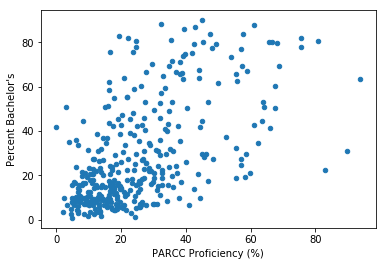

To save a single plot, we can do:

```
ax = df.plot()
ax.figure.savefig("my_plot.png")
```

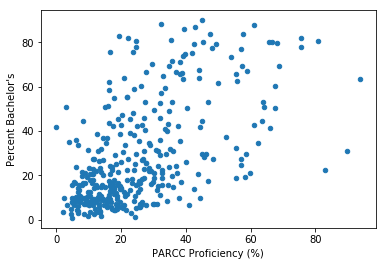

OR
```
from matplotlib import pyplot as plt

df.plot()
plt.savefig("my_plot2.png")
```

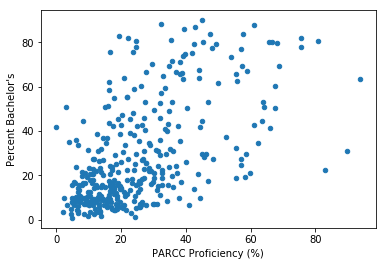

Pandas actually gives us a pretty cool utility for doing multiple variables at once:

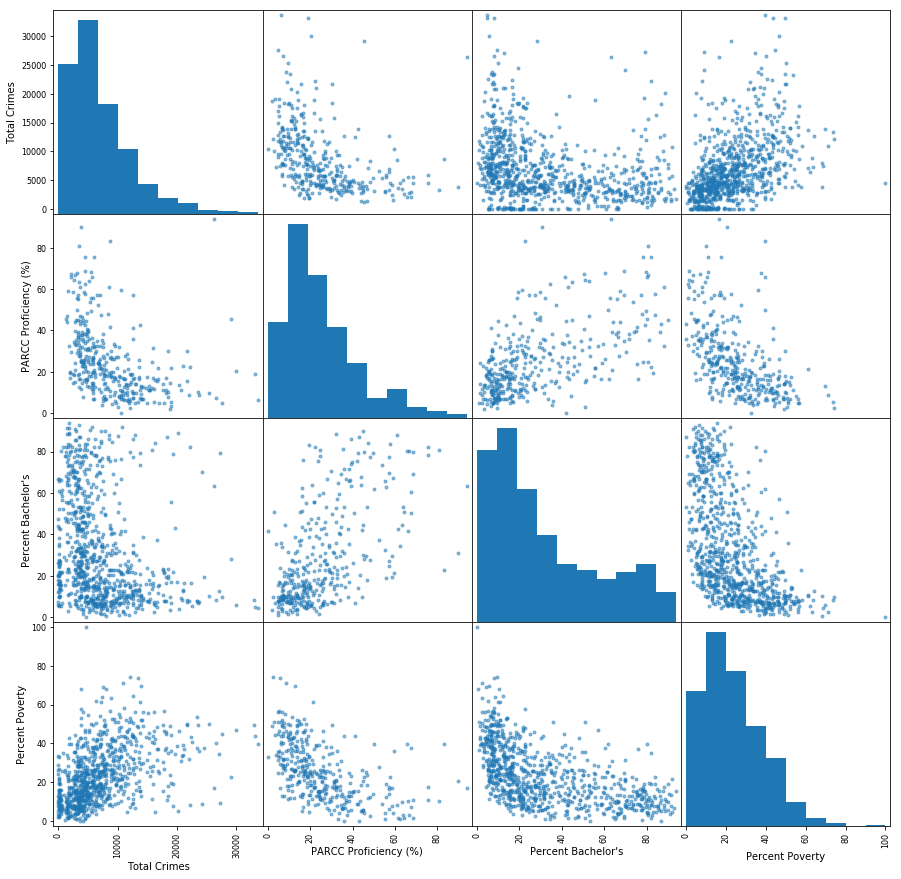

### Take-Aways

By lining up consistent columns across four datasets (schools, geocoded schools, census, crime), we can build a dataset that spans many observables in small neighborhoods across the city.

## Weather and Crime, Take One

In the introduction, we looked at the correlation between temperature and crime.

The crime data are from the same source as above, and the temperature data come from Weather Underground.  We'll see how to extract these next week, and do a larger example of it, in Week 9.

Let's start with the crimes.

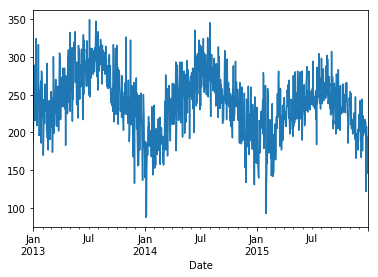

In [22]:
crime = pd.read_csv("data/evening_crime_agg.csv", index_col = 'Date', parse_dates = ['Date'])
ax = crime["Count"].plot()

This plot is unacceptable.  The y axis is not labeled, and the x axis is so-completely labeled as to be redundant.  

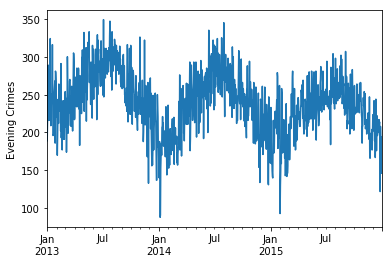

In [23]:
ax = crime["Count"].plot()
ax.set_xlabel("")
ax.set_ylabel("Evening Crimes")

That's better, but still pretty ugly.

To get better-looking plots (and some statistical features -- later), we can import seaborn and set some other defaults.  

Seaborn will immediately change the way that your plots look, usually for the better, for the entire session.

In general, I encourage you to use the [matplotlib](https://matplotlib.org/tutorials/index.html) and [seaborn](https://seaborn.pydata.org/index.html) documentation to make plots that look good.  Your plots should:

* Have labelled axes and legends if you're plotting more than one thing.  I will penalize if this is missing.
* Be readable -- the axes should be large but not overwhelmeing.

In [24]:
import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

If we do the exact same thing again, our plot looks better (I think).

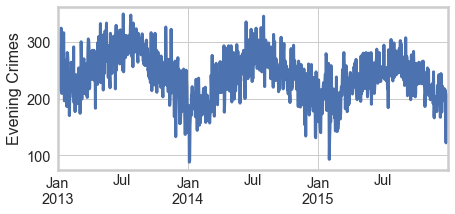

In [25]:
ax = crime["Count"].plot()
ax.set_xlabel("")
ax.set_ylabel("Evening Crimes")

Now let's do the same thing over again, with the weather data.

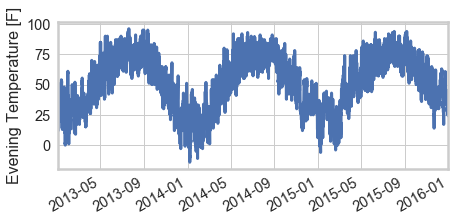

In [26]:
weather = pd.read_csv("data/MDW.csv",  index_col = 'DateUTC', parse_dates = ['DateUTC'])

ax = weather["Temperature [F]"].plot()
ax.set_xlabel("")
ax.set_ylabel("Evening Temperature [F]")

Let's have a peek at our data:

In [27]:
weather.head()

,Precipitation [In],Temperature [F]
DateUTC,,
2013-01-01 06:51:00,0.0,21.0
2013-01-01 07:51:00,0.0,21.0
2013-01-01 08:51:00,0.0,19.9
2013-01-01 09:51:00,0.0,19.0
2013-01-01 10:51:00,0.0,18.0


There's actually a little problem here -- this is saved in Greenwich Mean Time.  The time zone got converted away.  This is a bit of an abstruse problem, but it is one that you need to be aware of.  We can fix it pretty easiliy, in a single expressive but unintuitive line:

In [28]:
import pytz
weather.set_index(weather.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

weather.head()

,Precipitation [In],Temperature [F]
DateUTC,,
2013-01-01 00:51:00-06:00,0.0,21.0
2013-01-01 01:51:00-06:00,0.0,21.0
2013-01-01 02:51:00-06:00,0.0,19.9
2013-01-01 03:51:00-06:00,0.0,19.0
2013-01-01 04:51:00-06:00,0.0,18.0


This is more data than we want!  The crime data are for evenings only (after 6pm).  So let's do the same thing, here. 

In [29]:
evening_weather = weather[weather.index.hour > 18]
evening_weather = evening_weather.groupby(evening_weather.index.date).mean()

In [30]:
evening_weather.head()

,Precipitation [In],Temperature [F]
2013-01-01,0.0,14.80
2013-01-02,0.0,20.92
2013-01-03,0.0,21.80
2013-01-04,0.0,28.94
2013-01-05,0.0,35.50


In [31]:
crime.head()

,Count
Date,
2013-01-01,189
2013-01-02,213
2013-01-03,234
2013-01-04,289
2013-01-05,246


Now let's join these together.  Our indices match, so it's trivial -- use a join!!

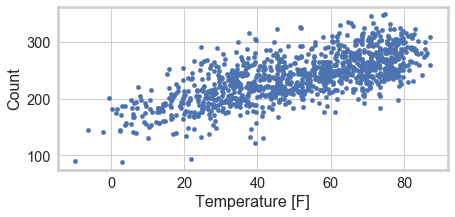

In [32]:
cw_merged = crime.join(evening_weather)
cw_merged.plot(kind = "scatter", x = "Temperature [F]", y = "Count");

Now let's ask a new question.  Do criminals avoid the rain?

In [33]:
cw_merged["Raining"] = cw_merged["Precipitation [In]"] > 0

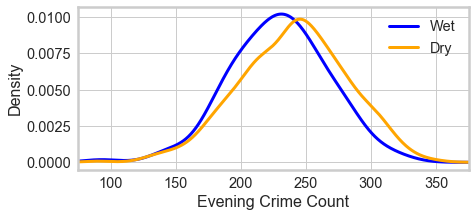

In [34]:
ax = cw_merged[ cw_merged.Raining]["Count"].plot(kind = "kde", color = "blue",)
cw_merged[~cw_merged.Raining]["Count"].plot(kind = "kde", color = "orange", ax = ax)
ax.legend(labels = ["Wet", "Dry"])
ax.set_xlim(75, 375)
ax.set_xlabel("Evening Crime Count")

Wow that looks pretty striking!  What's the appropriate test here?

For inspiration, check out https://docs.scipy.org/doc/scipy/reference/stats.html

(We'll come back to this in a few weeks!)

In [35]:
import scipy

In [36]:
scipy.stats.ttest_ind(cw_merged[ cw_merged.Raining]["Count"],
                      cw_merged[~cw_merged.Raining]["Count"])

Ttest_indResult(statistic=-3.218487718053527, pvalue=0.0013265777006113077)

What is the average evening crime rate by _day of the week_?

In [37]:
crime.groupby(crime.index.dayofweek).mean()

,Count
0,232.115385
1,234.898089
2,234.299363
3,233.101911
4,262.692308
5,246.326923
6,228.653846


So, Friday nights...